> There are part of trigger and transaction are tested so if you run all there's gonna be parts where it gonna return error (this is intentional) so please run the part after the error.

# Import library for analysis

In [1]:
!pip install openpyxl

In [2]:
!pip install psycopg2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for psycopg2: filename=psycopg2-2.9.9-cp310-cp310-linux_x86_64.whl size=157159 sha256=c21eebed2d956bce4294c57d22e9067ce335484698f0da4b0b23a69018554fd4
  Stored in directory: /home/trand11/.cache/pip/wheels/7d/75/13/da1c6d88687ae81bf5e3cfa07d702981ba137963163472b050
Successfully built psycopg2


In [3]:
import pandas as pd
from sqlalchemy import create_engine, schema, Table, text, Boolean, Null, DateTime, Column, String, Integer, MetaData, CheckConstraint, ForeignKeyConstraint, VARCHAR, NUMERIC, PrimaryKeyConstraint, ForeignKey, UniqueConstraint
import psycopg2
from psycopg2 import Error
import matplotlib.pyplot as plt
from datetime import datetime

# Database connection

In [4]:
# Here you define the credentials
DATABASE = 'group_10_2024' # TO BE REPLACED
USER = 'group_10_2024' # TO BE REPLACED
PASSWORD = 'r6x5eVqZRCIE' # TO BE REPLACED
HOST = 'dbcourse.cs.aalto.fi' 
PORT = '5432'

# Connection to the database
try :
    connection = psycopg2.connect (
        database = DATABASE ,
        user = USER ,
        password = PASSWORD ,
        host ='dbcourse.cs.aalto.fi',
        port = '5432'
)
    connection.autocommit = True 

except ( Exception , Error ) as error : # In case we fail to establish the connection
    print (" Error while connecting to PostgreSQL ", error )

# Create the database URL
db_url = f'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}'

# Create an engine instance
engine = create_engine(db_url)

# Delete existing tables

In [5]:
query = """
SELECT table_name 
FROM information_schema.tables 
WHERE table_schema = 'public' AND table_type = 'BASE TABLE';
"""

with connection.cursor() as cur:
    cur.execute(query)
    tables = cur.fetchall()
    
    for table in tables:
        drop_query = f"DROP TABLE {table[0]} CASCADE;"
        cur.execute(drop_query)
    
    connection.commit()

# Table creation

In [6]:
metadata = MetaData()

# Each city has an ID, a name, and a geolocation.
city = Table(
    'city', metadata,
    Column('name', VARCHAR(15), nullable = False),
    Column('id', VARCHAR(3), primary_key = True),
    Column('geolocation', VARCHAR(30), nullable = False)
)

# Volunteers on the other hand have unique ID, name, birthdate, email, address, readiness to travel (minutes).
volunteer = Table(
    'volunteer', metadata,
    Column('id',VARCHAR(11), primary_key = True),
    Column('birthdate', DateTime, nullable = False),
    Column('city_id', VARCHAR(3), ForeignKey('city.id'), nullable= False),
    Column('name', VARCHAR(50), nullable = False),
    Column('email', VARCHAR(50), nullable = False),
    Column('address', VARCHAR(50), nullable = False),
    Column('travel_readiness', Integer, nullable = False),
)

# Volunteers operate in ranges. Each volunteer range has a volunteer ID and a city ID
volunteer_range = Table(
    'volunteer_range', metadata,
    Column('volunteer_id', VARCHAR(11), ForeignKey('volunteer.id')),
    Column('city_id', VARCHAR(3), ForeignKey('city.id')),
    PrimaryKeyConstraint('volunteer_id','city_id')
)

# Each of these skills have a unique name and a description
skill = Table(
    'skill', metadata,
    Column('name', String, primary_key = True),
    Column('description', VARCHAR)
)


# Volunteers can also choose any combination of skills
skill_assignment = Table(
    'skill_assignment', metadata,
    Column('volunteer_id', VARCHAR(11), ForeignKey('volunteer.id')),
    Column('skill_name', String, ForeignKey('skill.name')),
    PrimaryKeyConstraint('volunteer_id', 'skill_name')
)

# Create a table that contains all the interest
interest = Table(
    'interest', metadata, 
    Column('name', String, primary_key = True)
)

# A volunteer can choose any combination of areas of interests
interest_assignment = Table(
    'interest_assignment', metadata,
    Column('interest_name', String, ForeignKey('interest.name')),
    Column('volunteer_id', VARCHAR(11), ForeignKey('volunteer.id')),
    PrimaryKeyConstraint('interest_name', 'volunteer_id')
)

# Beneficiaries have unique IDs, names, and addresses
beneficiary = Table(
    'beneficiary', metadata, 
    Column('id', VARCHAR, primary_key = True),
    Column('name', VARCHAR(50), nullable = False),
    Column('address', VARCHAR(50), nullable = False),
    Column('city_id', VARCHAR(3), ForeignKey('city.id'), nullable = False)
)

'''Requests should include a unique ID, the ID of the beneficiary it was sent by, the number of volunteers needed, a priority value to indicate
how urgent the request is (from 0 to 5, with 5 being highest priority), the area of interest where the request lies, a start date, an end date, and a register by date.'''
request = Table(
    'request', metadata, 
    Column('id', VARCHAR, primary_key = True),
    Column('title', String, nullable = False),
    Column('beneficiary_id', VARCHAR, ForeignKey('beneficiary.id'), nullable = False),
    Column('number_of_volunteers', Integer, nullable = False),
    Column('priority_value', Integer, nullable = False),
    Column('start_date', DateTime, nullable = False),
    Column('end_date', DateTime, nullable = False),
    Column('register_by_date', DateTime, nullable = False),
    CheckConstraint('priority_value >= 0 AND priority_value <= 5', name = 'check_priority_level')                
)

'''Beneficiaries can appraise skills by assigning the required skills for each request: a minimum need (minimum number of
volunteers who possess this skill), and a value to indicate importance (from 0 to 5, with 5 being highest priority).'''
request_skill = Table(
    'request_skill', metadata,
    Column('request_id', VARCHAR, ForeignKey('request.id')),
    Column('skill_name', String, ForeignKey('skill.name')),
    Column('min_need', Integer, nullable = False),
    Column('value', Integer, nullable = False),
    PrimaryKeyConstraint('request_id', 'skill_name'),
    CheckConstraint('value >= 0 AND value <= 5', name = 'check_value_importance'),
    CheckConstraint('min_need > 0', name = 'check_min_need')
)

# Each request location has a request ID and a city ID.
request_location = Table(
    'request_location', metadata,
    Column('request_id', VARCHAR, ForeignKey('request.id')),
    Column('city_id', VARCHAR(3), ForeignKey('city.id')),
    PrimaryKeyConstraint('request_id', 'city_id')
)

''' Volunteers can sign up to the system, browse through the volunteering requests, and send
up to 20 applications where they apply to the requests. Applications should include a
unique ID, the ID of the request it was made to, the ID of the volunteer it was sent by, the
time it was modified, and they should indicate whether they are valid or not.'''
volunteer_application = Table(
    'volunteer_application', metadata,
    Column('id', String, primary_key = True),
    Column('request_id', VARCHAR, ForeignKey('request.id')),
    Column('volunteer_id', VARCHAR(11), ForeignKey('volunteer.id')),
    Column('modified', DateTime, nullable = False),
    Column('is_valid', Boolean, nullable = False),
    UniqueConstraint('volunteer_id', 'request_id')
)

# This is create for the free choice transaction 
potential_volunteer = Table(
    'potential_volunteer', metadata, 
    Column('request_id', VARCHAR, ForeignKey('request.id')),
    Column('volunteer_id', VARCHAR(11), ForeignKey('volunteer.id')),
    PrimaryKeyConstraint('request_id', 'volunteer_id')
)

metadata.create_all(engine)

In [7]:
#Define constraint for maximum of 20 active application per volunteers
query = """
    DROP trigger if exists check_volunteer_application_limit on volunteer_application; 

    CREATE OR REPLACE FUNCTION check_volunteer_application_limit()
    RETURNS TRIGGER AS $$
    DECLARE
        count_ INT;
    BEGIN
        select count(*)
        into count_
        from volunteer_application va
        join request r on va.request_id = r.id
        where r.register_by_date >= current_timestamp;
    
        IF count_ = 20 THEN
                RAISE EXCEPTION 'Volunteer reaches the maximum number of active application allowed';
        END IF;
        RETURN NEW;
    END;
    $$ LANGUAGE plpgsql;

    CREATE TRIGGER check_volunteer_application_limit
    AFTER INSERT ON volunteer_application
    FOR EACH ROW
    EXECUTE FUNCTION check_volunteer_application_limit();
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    con.execute(text(query))
    con.commit()

# Reading csv and data cleaning

In [8]:
# Read the excel file
data = pd.ExcelFile('data.xlsx')

In [9]:
# Check if the data contains all of the neccessary sheets 
data.sheet_names

['city',
 'volunteer',
 'volunteer_range',
 'skill',
 'skill_assignment',
 'interest',
 'interest_assignment',
 'beneficiary',
 'request',
 'request_skill',
 'request_location',
 'volunteer_application']

In [10]:
# Create a dictionary to store DataFrames for each sheet
dfs = {}

# Iterate through each sheet name and parse the sheet into a DataFrame
for name in data.sheet_names:
    dfs[name] = data.parse(name)

In [11]:
# Change the data type of elements in the dataframe to fit with the datatype of the database tables
dfs['city']['id'] = dfs['city']['id'].astype('str')
dfs['volunteer']['city_id'] = dfs['volunteer']['city_id'].astype('str')
dfs['volunteer_range']['city_id'] = dfs['volunteer_range']['city_id'].astype('str')
dfs['beneficiary'][['id', 'city_id']] = dfs['beneficiary'][['id','city_id']].astype('str')
dfs['request'][['id', 'beneficiary_id']] = dfs['request'][['id', 'beneficiary_id']].astype('str')
dfs['request_skill']['request_id'] = dfs['request_skill']['request_id'].astype('str')
dfs['request_location'][['request_id', 'city_id']] = dfs['request_location'][['request_id', 'city_id']].astype('str')
dfs['volunteer_application'][['id', 'request_id']] = dfs['volunteer_application'][['id', 'request_id']].astype('str')

> Map the data

In [12]:
dataframes_mapping = {}

# Define the specifications dictionary
specifications = {
    'table_name': '',
    'if_exists': 'append'
}

# Iterate over the dataframes
for sheet_name, dataframe in dfs.items():
    # Create a copy of the specifications dictionary for each dataframe
    dataframe_specifications = specifications.copy()
    
    # Assign the dataframe-specific values to the copied dictionary
    dataframe_specifications['table_name'] = sheet_name
    
    # Assign the dataframe-specific dictionary to the dataframes_mapping dictionary
    dataframes_mapping[sheet_name] = {
        'dataframe': dataframe,
        **dataframe_specifications
    }

> Insert the data into database

In [13]:
con = engine.connect() 
for key, value in dataframes_mapping.items():
    dataframe = value['dataframe']
    table_name = value['table_name']
    if_exists = value['if_exists']

    dataframe.to_sql(table_name, con, if_exists = if_exists, index = False)
    print(f'Complete insert into table: {table_name}')
con.commit()
con.close()

Complete insert into table: city
Complete insert into table: volunteer
Complete insert into table: volunteer_range
Complete insert into table: skill
Complete insert into table: skill_assignment
Complete insert into table: interest
Complete insert into table: interest_assignment
Complete insert into table: beneficiary
Complete insert into table: request
Complete insert into table: request_skill
Complete insert into table: request_location
Complete insert into table: volunteer_application


# Part 3A Basic

1. (2p) For each request, include the starting date and the end date in the title.

In [14]:
# Update title column in request table to include start_date and end_date
query = """
    update request 
    set title = concat(title, ' from ', start_date, ' to ', end_date);
"""
with engine.connect() as con: 
    con.execute(text(query))
    con.commit()

In [15]:
# print out the updated value
query = """
    SELECT id, title
    from request;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

df

,id,title
0,1,work in team needed from 2024-07-25 22:15:00 t...
1,2,work with young needed from 2022-05-31 04:15:0...
2,3,guide and teach needed from 2024-07-22 22:15:0...
3,4,guide and teach needed from 2024-09-25 02:30:0...
4,5,work with elderly needed from 2021-03-01 01:15...
...,...,...
377,378,work with young needed from 2021-12-29 23:30:0...
378,379,immigrant support needed from 2020-07-07 00:00...
379,380,work with young needed from 2020-07-11 23:15:0...
380,381,work with young needed from 2024-06-24 00:15:0...


2. (3p) For each request, find volunteers whose skill assignments match the
requesting skills. List these volunteers from those with the most matching
skills to those with the least (even 0 matching skills). Only consider
volunteers who applied to the request and have a valid application.

In [16]:
# Create a CTE volunteer_matching to find the valid volunteer_application and map out the request_skill and volunteer_skill and count case to find the number of skills matched
query = """
	with volunteer_matching as (
		select va.id, 
			va.request_id,
			va.volunteer_id, 
			sa.skill_name as volunteer_skill,
			rs.skill_name as request_skill
		from volunteer_application va 
		left join request_skill rs on va.request_id = rs.request_id 
		left join skill_assignment sa on va.volunteer_id = sa.volunteer_id 
		where va.is_valid = true 
	)
	select request_id, 
		volunteer_id, 
		count(case when volunteer_skill = request_skill then 1 end) as matched_skills
	from volunteer_matching
	group by request_id, volunteer_id
	order by request_id::numeric, matched_skills desc; 
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

df

,request_id,volunteer_id,matched_skills
0,1,230283-963X,3
1,1,211074-9401,1
2,1,160903A941P,1
3,1,250681-919H,1
4,1,011074-9149,1
...,...,...,...
2429,382,010573-901K,7
2430,382,231269-913S,5
2431,382,100396-906V,3
2432,382,200472-937X,1


3. (3p) For each request, show the missing number of volunteers needed per
skill (minimum needed of that skill). Assume a volunteer fulfills the need for all
the skills they possess.

In [17]:
# Join 3 tables request_skill, skill_assignment, and volunteer_application together and find the greatest difference between (min_need - total_apply) and 0 
# to find the skills in each request that are missing volunteer
query = """
	select va.request_id ,
			rs.skill_name,
			greatest (rs.min_need - count(*), 0) as missing_volunteer
	from request_skill rs 
	left join skill_assignment sa on rs.skill_name = sa.skill_name
	left join volunteer_application va on sa.volunteer_id = va.volunteer_id
	where rs.request_id = va.request_id and va.is_valid = true
	group by va.request_id,
			rs.skill_name,
			rs.min_need
	order by cast(va.request_id as int) asc, missing_volunteer desc;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

df

,request_id,skill_name,missing_volunteer
0,1,CommunicationAndMarketing,2
1,1,EventOrganization,1
2,1,EventHosting,1
3,1,PhotographyAndVideo,0
4,2,CookingAndBaking,2
...,...,...,...
1827,382,TrainPeople,1
1828,382,EventHosting,1
1829,382,EventOrganization,0
1830,382,MeetingPeople,0


4. (3p) Sort requests and the beneficiaries who made them by the highest
number of priority (requestʼs priority value) and the closest 'register by date'.

In [18]:
# For each priority level, find the beneficiary who have the closest request id to current_timestamp 
# It is assumed that the request of interest is those whose register_by_date have not yet passed 
query = """
    SELECT 
        priority_value, 
        beneficiary_id,
        id, 
        register_by_date 
    FROM request r
    WHERE r.register_by_date >= CURRENT_TIMESTAMP
    ORDER BY 
        priority_value ASC,
        register_by_date asc;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

df

,priority_value,beneficiary_id,id,register_by_date
0,0,1,181,2024-06-29 15:30:00
1,0,6,256,2024-07-18 19:00:00
2,0,1,20,2024-07-25 09:29:00
3,0,2,247,2024-07-29 19:00:00
4,0,4,154,2024-07-31 23:00:00
...,...,...,...,...
104,5,1,335,2024-09-23 19:30:00
105,5,1,106,2024-09-25 08:00:00
106,5,5,276,2024-10-03 17:00:00
107,5,9,226,2024-10-29 05:30:00


5. (3p) For each volunteer, list requests that are within their volunteer range and
match at least 2 of their skills (also include requests that donʼt require any
skills).

In [19]:
# 3 CTEs: city_request_matched which find the volunteer id that has at least one operation range that is required in the request_location of the request id
# request_skill_matched to find the count of matched skills for a request id and the volunteer id with the condition that at least 2 skills are matched
# request_no_skill to find the volunteer id and request id mapping that do not require a skill
# Join the city_request_matched and request_skill_matched together and then union with city_request_matched join with request_no_skill to find all the combinations
query = """
    WITH city_request_matched AS (
        SELECT 
            v.id AS volunteer_id, 
            r.id AS request_id, 
            rl.city_id AS city_id, 
            vr.city_id AS range_city_d 
        FROM 
            request r
        JOIN 
            request_location rl ON r.id = rl.request_id 
        JOIN 
            volunteer_range vr ON vr.city_id = rl.city_id 
        JOIN 
            volunteer v ON v.id = vr.volunteer_id 
    ), 
    request_skill_matched AS (
        SELECT 
            rs.request_id AS request_id, 
            sa.volunteer_id AS volunteer_id, 
            COUNT(DISTINCT sa.skill_name) AS count_skill 
        FROM 
            request r 
        JOIN 
            request_skill rs ON rs.request_id = r.id 
        JOIN 
            skill_assignment sa ON sa.skill_name = rs.skill_name 
        GROUP BY 
            rs.request_id, sa.volunteer_id
        HAVING 
            COUNT(DISTINCT sa.skill_name) >= 2
    ), 
    request_no_skill AS (
        SELECT 
            id AS request_id 
        FROM 
            request 
        WHERE 
            id NOT IN (SELECT request_id FROM request_skill)
    )
    SELECT * FROM (
        SELECT 
            city_request_matched.volunteer_id AS volunteer_id,
            city_request_matched.request_id AS request_id,
            request_skill_matched.count_skill   
        FROM 
            city_request_matched 
        JOIN 
            request_skill_matched ON city_request_matched.volunteer_id = request_skill_matched.volunteer_id 
            AND city_request_matched.request_id = request_skill_matched.request_id
        UNION
        SELECT 
            city_request_matched.volunteer_id AS volunteer_id, 
            city_request_matched.request_id AS request_id, 
            0 
        FROM 
            city_request_matched
        JOIN 
            request_no_skill ON city_request_matched.request_id = request_no_skill.request_id
    ) AS unioned_results
    ORDER BY 
        volunteer_id, 
        CAST(request_id AS INTEGER);
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

df

,volunteer_id,request_id,count_skill
0,010469-981A,1,3
1,010469-981A,2,7
2,010469-981A,5,3
3,010469-981A,6,5
4,010469-981A,10,4
...,...,...,...
28441,311267-9044,370,2
28442,311267-9044,372,2
28443,311267-9044,379,2
28444,311267-9044,381,4


6. (3p) For each volunteer, list all the requests where the title matches their area
of interest and are still available to register.

In [20]:
# Convert the title in the request to interest name and match the volunteer together by joining request_convert with interet_assignment to find the matching interest 
# With the condition that register_by_date >= current_timestamp to ensure the request is still open for registration
query = """
    WITH request_convert AS (
    SELECT *,
           CASE 
               WHEN title like '%collect donations needed%' THEN 'CollectDonations'
               WHEN title like '%first aid needed%' THEN 'FirstAid'
               WHEN title like '%food help needed%' THEN 'FoodHelp'
               WHEN title like '%guide and teach needed%' THEN 'GuideAndTeach'
               WHEN title like '%help in crisis needed%' THEN 'HelpInCrisis'
               WHEN title like '%immigrant support needed%' THEN 'ImmigrantSupport'
               WHEN title like '%organise activities needed%' THEN 'OrganiseActivities'
               WHEN title like '%promote wellbeing needed%' THEN 'PromoteWellbeing'
               WHEN title like '%work in multicultural environment needed%' THEN 'WorkInMulticulturalEnvironment'
               WHEN title like '%work in team needed%' THEN 'WorkInATeam'
               WHEN title like '%work with elderly needed%' THEN 'WorkWithElderly'
               WHEN title like '%work with young needed%' THEN 'WorkWithYoung'
           end as interest_name
    FROM request 
)
    SELECT ia.volunteer_id, rc.id as request_id
    FROM request_convert rc
    join interest_assignment ia on rc.interest_name = cast(ia.interest_name as text)
    where rc.register_by_date >= current_timestamp
    order by ia.volunteer_id;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

df

,volunteer_id,request_id
0,010469-981A,24
1,010469-981A,62
2,010469-981A,308
3,010469-981A,266
4,010469-981A,286
...,...,...
11231,311267-9044,326
11232,311267-9044,96
11233,311267-9044,62
11234,311267-9044,276


7. (3p) List the request ID and the volunteers who applied to them (name and
email) but are not within the location range of the request. Order volunteers
by readiness to travel.

In [21]:
# Create a CTE to find the unique combination of request_id and volunteer_id that has the same volunteer_range as request_location range
# List the request ID and the volunteers who request_id and volunteer_id combination is not in the sub querry of cte with is_valid = True to account for only valid application
query = """
    with cte as (
	SELECT DISTINCT va.request_id, va.volunteer_id
	FROM volunteer_application va
	JOIN request_location rl ON va.request_id = rl.request_id
	JOIN volunteer_range vr ON va.volunteer_id = vr.volunteer_id 
	WHERE rl.city_id = vr.city_id
)
SELECT DISTINCT cast(va.request_id as int), va.volunteer_id, v."name", v.email, v.travel_readiness
	FROM volunteer_application va
	JOIN request_location rl ON va.request_id = rl.request_id
	JOIN volunteer_range vr ON va.volunteer_id = vr.volunteer_id 
	JOIN volunteer v ON v.id = vr.volunteer_id 
	WHERE va.volunteer_id not in (
		select volunteer_id
		from cte
		where va.request_id = cte.request_id
	) and va.is_valid = True
	group by va.request_id, va.volunteer_id, v."name", v.email, v.travel_readiness 
	ORDER BY cast(va.request_id as int), v.travel_readiness asc;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

df

,request_id,volunteer_id,name,email,travel_readiness
0,1,230283-963X,Mikko Rossi,mikko.rossi@dbcourse.cs.aalto.fi,680
1,2,101003A9918,Kari Lampinen-Heikkinen,kari.lampinen-heikkinen@dbcourse.cs.aalto.fi,404
2,2,190697-999B,Anton Ketola,anton.ketola@dbcourse.cs.aalto.fi,943
3,3,200958-9326,Ilona Nieminen,ilona.nieminen@dbcourse.cs.aalto.fi,695
4,3,190697-999B,Anton Ketola,anton.ketola@dbcourse.cs.aalto.fi,943
...,...,...,...,...,...
926,380,231259-9690,Mika Martikainen,mika.martikainen@dbcourse.cs.aalto.fi,224
927,380,210856-966L,Ilona Virtanen,ilona.virtanen@dbcourse.cs.aalto.fi,815
928,381,240588-937E,Paavo Kuusisto,paavo.kuusisto@dbcourse.cs.aalto.fi,1418
929,382,010573-901K,Juhani Pesonen,juhani.pesonen@dbcourse.cs.aalto.fi,707


8. (3p) Order the skills overall (from all requests) in the most prioritized to least
prioritized (average the importance value).

In [22]:
# Find the average importance of each skill and group by skill_name and order by the avg desc to find the most importance skills
query = """
    select skill_name, round(avg(value), 2) as overall_importance
from request_skill rs
group by skill_name 
order by round(avg(value), 2) desc;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

df

,skill_name,overall_importance
0,CookingAndBaking,2.70
1,PublicPerformances,2.55
2,HealthCareOrFirstAid,2.55
3,Rescue,2.52
4,DigitalCompetence,2.51
5,TeamGuide,2.51
6,CommunicationAndMarketing,2.49
7,FinanceAndAccounting,2.47
8,EventOrganization,2.46
9,TrainPeople,2.42


9. For each request, find the most suitable person for that request, where the most suitable means having the highest number of skill matches. (The person must have applied for the request and is_valid = True)

In [23]:
# Create a CTE to find the number of skills that a volunteer has in common with the request 
# From the CTE extract the combincation of request id and volunteer id who can offer the highest number of required skills
query = """
    with ctes as(
            select r.id as request_id, va.volunteer_id, count(*) as num_skill
            from request r 
            join request_skill rs on r.id = rs.request_id 
            join volunteer_application va on r.id = va.request_id 
            join skill_assignment sa on sa.volunteer_id = va.volunteer_id 
            where rs.skill_name = sa.skill_name
            group by r.id, va.volunteer_id
            order by r.id, count(*) desc
        )
        select ctes.request_id, ctes.volunteer_id, ctes.num_skill
        from ctes
        join (select request_id, max(num_skill) as max_skill
        from ctes
        group by request_id
        order by request_id) ctes2
        on ctes.request_id = ctes2.request_id
        where ctes.num_skill = ctes2.max_skill
        order by ctes.request_id::numeric;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

df

,request_id,volunteer_id,num_skill
0,1,230283-963X,3
1,2,190697-999B,6
2,3,190697-999B,7
3,4,010573-901K,6
4,4,250684-9410,6
...,...,...,...
619,380,101156-956L,6
620,381,120982-9892,5
621,381,020759-9272,5
622,381,080474-9161,5


10. For each beneficiary, determine the skill that is requested the most 


In [24]:
# Create a sub querry to find the total number of recent request for each skill_name 
# WITHIN 6 months from the current timestamp in the past or has not ended registration yet
# and find the top skills that is requested the most by each beneficiary
query = """
    SELECT id, name, skill_name, total_number_of_recent_request
    FROM (
        SELECT b.id, b.name, rs.skill_name, COUNT(*) AS total_number_of_recent_request,
            ROW_NUMBER() OVER (PARTITION BY b.id ORDER BY COUNT(*) DESC) AS row_number
        FROM request_skill rs
        JOIN request r ON rs.request_id = r.id
        JOIN beneficiary b ON r.beneficiary_id = b.id
        WHERE r.end_date > current_timestamp OR r.start_date >= (current_timestamp - INTERVAL '6 months')
        GROUP BY b.id, b.name, rs.skill_name
    ) AS subquery
    WHERE row_number <= 3
    ORDER BY CAST(id AS INT), total_number_of_recent_request DESC;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

df

,id,name,skill_name,total_number_of_recent_request
0,1,Hospital,Rescue,10
1,1,Hospital,CookingAndBaking,9
2,1,Hospital,PublicPerformances,7
3,2,Food Bank,EventHosting,10
4,2,Food Bank,TeamGuide,9
5,2,Food Bank,Organizational,7
6,3,Elderly Care,EventOrganization,8
7,3,Elderly Care,PhotographyAndVideo,7
8,3,Elderly Care,CommunicationAndMarketing,7
9,4,Youth Centre,EventOrganization,10


11. Order the skills based on the number of requests 

In [25]:
# Find the total number of requests made by beneficiaries per skill and order by the highest requested skills 
query = """
    select r.skill_name, count(distinct r.request_id) as total_number_of_request 
    from request_skill r
    join request r2 ON r.request_id = r2.id
    where r2.end_date > current_timestamp OR r2.start_date >= (current_timestamp - INTERVAL '6 months')
    group by r.skill_name
    order by r.skill_name, count(distinct r.request_id) desc; 
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

df

,skill_name,total_number_of_request
0,CommunicationAndMarketing,59
1,CookingAndBaking,59
2,DigitalCompetence,51
3,EventHosting,62
4,EventOrganization,57
5,FinanceAndAccounting,56
6,HealthCareOrFirstAid,46
7,MeetingPeople,50
8,Organizational,62
9,PhotographyAndVideo,52


12. For each request, find people located in that location and who have at least 2 matching skills, but do not apply.

In [26]:
# Join Tables: Combines data from requests, volunteer applications, request locations, volunteer ranges, request skills, and volunteer skill assignments.
# Filter: Ensures volunteers did not apply to the specific requests but are within the request's location range.
# Match Skills: Checks that volunteers have at least two of the skills required by the request.
# Group and Count: Groups by request and volunteer, counting the number of matching skills.
# Filter by Skill Count: Includes only those groups with at least 2 matching skills.
query = """
    with cte as(
    select r.id as request_id,va.volunteer_id as volunteer_id, rs.skill_name
    from request r 
    join volunteer_application va ON r.id <> va.request_id 
    join request_location rl on rl.request_id = r.id
    join volunteer_range vr on vr.volunteer_id = va.volunteer_id and vr.city_id = rl.city_id 
    join request_skill rs on rs.request_id = va.request_id 
    join skill_assignment sa on sa.volunteer_id = vr.volunteer_id and sa.skill_name = rs.skill_name 
    group by r.id, va.volunteer_id , rs.skill_name 
    )
    select request_id, volunteer_id, count(*) from cte
    group by request_id, volunteer_id
    having count(*) >=2 
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

df

,request_id,volunteer_id,count
0,229,150960-943U,7
1,104,070494-922R,7
2,157,290464-9503,3
3,153,230605A923R,9
4,182,111276-945V,6
...,...,...,...
40462,115,101290-902E,8
40463,116,241254-9934,5
40464,23,211074-9401,2
40465,104,220782-910B,7


# Part 3B, Advanced

## a. Views

1. (5p) Create a view that lists next to each beneficiary the average number of
volunteers that applied, the average age that applied, and the average
number of volunteers they need across all of their requests.

In [27]:
# The beneficiary_average view calculates three key metrics for each beneficiary: the average number of unique volunteers per request, 
# the average age of volunteers, and the average number of volunteers needed per request. 
# It uses three CTEs to compute these metrics and then combines them into a final result. 
query = """
    create or replace view beneficiary_average as(
	WITH average_volunteer_apply AS (
	    SELECT r.beneficiary_id, b.name, 
	    	round((COUNT(va.volunteer_id)::numeric / COUNT(DISTINCT va.request_id)), 1) AS average_volunteer_application
	    FROM request r
	    JOIN volunteer_application va ON r.id = va.request_id
	    JOIN beneficiary b ON b.id = r.beneficiary_id
	    group by r.beneficiary_id, b.name
	),
	average_age AS (
		    SELECT distinct_volunteers.beneficiary_id, b.name,
	       ROUND(AVG(EXTRACT(YEAR FROM AGE(current_timestamp, distinct_volunteers.birthdate)))::NUMERIC, 1) AS avg_volunteer_age
	FROM (
	    SELECT DISTINCT r.beneficiary_id, va.volunteer_id, v.birthdate
	    FROM request r
	    JOIN volunteer_application va ON r.id = va.request_id
	    JOIN volunteer v ON va.volunteer_id = v.id
	) AS distinct_volunteers 
	JOIN beneficiary b ON distinct_volunteers.beneficiary_id = b.id
	GROUP BY distinct_volunteers.beneficiary_id, b.name
	),
	average_volunteer_needed AS (
	    SELECT r.beneficiary_id, b.name, 
	    	ROUND(AVG(r.number_of_volunteers), 1) AS avg_volunteer_needed
	    FROM request r 
	    JOIN beneficiary b ON r.beneficiary_id = b.id
	    group by r.beneficiary_id, b.name
	)
	SELECT ava.beneficiary_id, ava.name, average_volunteer_application, avg_volunteer_age, avg_volunteer_needed
	FROM average_volunteer_apply ava
	join average_age aa on ava.beneficiary_id = aa.beneficiary_id
	join average_volunteer_needed avn on ava.beneficiary_id = avn.beneficiary_id
);
"""
with engine.connect() as con: 
    con.execute(text(query))
    con.commit()

In [28]:
# Display the view result
query = """
    select * from beneficiary_average;
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

df

,beneficiary_id,name,average_volunteer_application,avg_volunteer_age,avg_volunteer_needed
0,1,Hospital,6.3,43.9,20.7
1,2,Food Bank,7.6,43.6,19.0
2,3,Elderly Care,7.4,44.7,17.9
3,4,Youth Centre,7.5,43.4,17.8
4,5,Homeless Shelter,7.6,44.4,17.4
5,6,Blood-Drive (PA),6.5,42.7,16.7
6,7,Event First-Aid,7.0,43.4,19.1
7,8,Immigration,7.5,43.9,19.4
8,9,Local Branch,6.7,45.3,21.1


2. Create a view to compare the number of volunteers who have an interest and the number of volunteer apply to that interest 

In [29]:
# Create 3 CTEs
# request_with_interest to map out the title with interest_name
# volunteer_own_interest_count to find the total volunteer with that interest
# volunteer_applied_interest_count to find the total request the volunteer apply to of that interest and compare them
query = """
    create or replace view skill_owned_and_requested as(
    WITH request_with_interest AS (
        SELECT *,
            CASE 
                WHEN title like '%collect donations needed%' THEN 'CollectDonations'
                WHEN title like '%first aid needed%' THEN 'FirstAid'
                WHEN title like '%food help needed%' THEN 'FoodHelp'
                WHEN title like '%guide and teach needed%' THEN 'GuideAndTeach'
                WHEN title like '%help in crisis needed%' THEN 'HelpInCrisis'
                WHEN title like '%immigrant support needed%' THEN 'ImmigrantSupport'
                WHEN title like '%organise activities needed%' THEN 'OrganiseActivities'
                WHEN title like '%promote wellbeing needed%' THEN 'PromoteWellbeing'
                WHEN title like '%work in multicultural environment needed%' THEN 'WorkInMulticulturalEnvironment'
                WHEN title like '%work in team needed%' THEN 'WorkInATeam'
                WHEN title like '%work with elderly needed%' THEN 'WorkWithElderly'
                WHEN title like '%work with young needed%' THEN 'WorkWithYoung'
            end as interest_name
        FROM request 
    ), volunteer_own_interest_count as (
        select interest_name, count(*) as count_volunteer_own_interest from interest_assignment  group by interest_name
    ), volunteer_applied_interest_count as (
        select request_with_interest.interest_name, count(*) as count_volunteer_applied_interest from volunteer_application va 
        join request_with_interest on va.request_id = request_with_interest.id
        group by request_with_interest.interest_name

    )
    select volunteer_own_interest_count.interest_name,volunteer_own_interest_count.count_volunteer_own_interest,volunteer_applied_interest_count.count_volunteer_applied_interest from volunteer_applied_interest_count
    join volunteer_own_interest_count on volunteer_own_interest_count.interest_name = volunteer_applied_interest_count.interest_name
    );
"""
with engine.connect() as con: 
    con.execute(text(query))
    con.commit()

In [30]:
# Display the view result
query = """
    select * from skill_owned_and_requested;
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

df

,interest_name,count_volunteer_own_interest,count_volunteer_applied_interest
0,ImmigrantSupport,100,219
1,OrganiseActivities,105,191
2,WorkInMulticulturalEnvironment,103,239
3,WorkWithElderly,102,246
4,FoodHelp,103,195
5,FirstAid,104,212
6,PromoteWellbeing,100,223
7,WorkInATeam,98,217
8,HelpInCrisis,93,214
9,GuideAndTeach,104,264


## b. Trigger and Functions

1. Create a check constraint for the volunteer table with a function that
validates a volunteer ID when a new volunteer is inserted

> Create trigger

In [31]:
# Define trigger
query = """
    DROP trigger if exists validate_volunteer_id on volunteer;

    CREATE OR REPLACE FUNCTION check_volunteer_id()
    RETURNS TRIGGER AS $$
    DECLARE
        control_characters TEXT[] := ARRAY[
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 
            'H', 'J', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'
        ];
        concatenated_id INT;
        remainder INT;
    BEGIN
        -- Check the birthdate and specific character rules
        IF (EXTRACT(YEAR FROM NEW.birthdate) < 1900 AND SUBSTRING(NEW.id, 7, 1) NOT IN ('+')) OR
        (EXTRACT(YEAR FROM NEW.birthdate) BETWEEN 1900 AND 1999 AND SUBSTRING(NEW.id, 7, 1) NOT IN ('-', 'Y', 'X', 'W', 'V', 'U')) OR
        (EXTRACT(YEAR FROM NEW.birthdate) BETWEEN 2000 AND 2999 AND SUBSTRING(NEW.id, 7, 1) NOT IN ('A', 'B', 'C', 'D', 'E', 'F'))
        THEN
            RAISE EXCEPTION 'ID is invalid';
        END IF;

        -- Calculate the remainder and check the control character
        concatenated_id := CAST(CONCAT(SUBSTRING(NEW.id, 1, 6), SUBSTRING(NEW.id, 8, 3)) AS INT);
        remainder := MOD(concatenated_id, 31);

        IF SUBSTRING(NEW.id, 11, 1) != control_characters[remainder + 1] THEN
            RAISE EXCEPTION 'ID is invalid';
        END IF;

        RETURN NEW;
    END;
    $$ LANGUAGE plpgsql;


    CREATE TRIGGER validate_volunteer_id
    BEFORE INSERT OR UPDATE ON volunteer
    FOR EACH ROW
    EXECUTE FUNCTION check_volunteer_id();
"""
with engine.connect() as con: 
    con.execute(text(query))
    con.commit()

> Test trigger

Correct id

In [32]:
# Define the query
query = """
    DELETE FROM volunteer WHERE id = '100101A719P';
    
    insert into volunteer values
    ('100101A719P', '2001-10-01 00:00:00', '426', 'Testi', 'testi.@aalto.fi', 'Kampi', '100');
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    con.execute(text(query))
    con.commit()

query = """
    select * 
    from volunteer
    where id = '100101A719P'
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)


# Delete the tested volunteer id from the table
query = """
    DELETE FROM volunteer WHERE id = '100101A719P';
"""

# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    con.execute(text(query))
    con.commit()

print(df)

            id  birthdate city_id   name            email address  \
0  100101A719P 2001-10-01     426  Testi  testi.@aalto.fi   Kampi   

   travel_readiness  
0               100  


Wrong id

In [33]:
# Define the query
query = """    
    insert into volunteer values
    ('101212A719A', '2001-10-01 00:00:00', '426', 'Testi', 'testi.@aalto.fi', 'Kampi', '100');
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    con.execute(text(query))
    con.commit()

    

InternalError: (psycopg2.errors.RaiseException) ID is invalid
CONTEXT:  PL/pgSQL function check_volunteer_id() line 23 at RAISE

[SQL:     
    insert into volunteer values
    ('101212A719A', '2001-10-01 00:00:00', '426', 'Testi', 'testi.@aalto.fi', 'Kampi', '100');
]
(Background on this error at: https://sqlalche.me/e/20/2j85)

2. (5p) Create a trigger that updates the number of volunteers for a request
whenever the minimum need for any of its skill requirements is changed. The
total number of volunteers needed for each request is calculated as the sum
of unskilled volunteers (those without any skill requirements) and the
minimum need for each required skill.

> Create trigger

In [34]:
# Define the query
query = """
    DROP trigger if exists update_request_number_of_volunteers on request_skill; 

    CREATE OR REPLACE FUNCTION update_request_number_of_volunteers()
    RETURNS TRIGGER AS $$
    DECLARE
        difference INT;
    BEGIN
        IF TG_OP = 'UPDATE' THEN
            difference := OLD.min_need - NEW.min_need;
        ELSIF TG_OP = 'DELETE' THEN
            difference := OLD.min_need; -- Add back the deleted skill's min_need
        ELSIF TG_OP = 'INSERT' THEN
            difference := -NEW.min_need; -- Subtract the added skill's min_need
        END IF;

        UPDATE request
        SET number_of_volunteers = number_of_volunteers - difference
        WHERE request.id = NEW.request_id;
        
        RETURN NEW;
    END;
    $$ LANGUAGE plpgsql;

    CREATE TRIGGER update_request_number_of_volunteers
    AFTER INSERT OR UPDATE OR DELETE ON request_skill
    FOR EACH ROW
    EXECUTE FUNCTION update_request_number_of_volunteers();
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    con.execute(text(query))
    con.commit()

> Test trigger

Increase value min_need by 1

In [35]:
query = """
    select * from request_skill 
    where request_id = '1'and skill_name = 'EventHosting';
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

print("Request skill before changes: ")
print(df)


Request skill before changes: 
  request_id    skill_name  min_need  value
0          1  EventHosting         3      2


In [36]:
query = """
    select * from request where id = '1';
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

print("Request number of volunteers before changes: ")
print(df)

Request number of volunteers before changes: 
  id                                              title beneficiary_id  \
0  1  work in team needed from 2024-07-25 22:15:00 t...              3   

   number_of_volunteers  priority_value          start_date  \
0                    14               1 2024-07-25 22:15:00   

             end_date    register_by_date  
0 2024-07-28 18:00:00 2024-07-18 01:00:00  


In [37]:
query = """
    update request_skill 
    set min_need = min_need + 1 
    where request_id = '1' and skill_name = 'EventHosting';
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    con.execute(text(query))
    con.commit()


In [38]:

query = """
    select * from request_skill 
    where request_id = '1'and skill_name = 'EventHosting';

"""
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

print("Request skill after changes: ")
print(df)

Request skill after changes: 
  request_id    skill_name  min_need  value
0          1  EventHosting         4      2


In [39]:
query = """
    select * from request where id = '1';
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

print("Request number of volunteer after changes: ")
print(df)

Request number of volunteer after changes: 
  id                                              title beneficiary_id  \
0  1  work in team needed from 2024-07-25 22:15:00 t...              3   

   number_of_volunteers  priority_value          start_date  \
0                    15               1 2024-07-25 22:15:00   

             end_date    register_by_date  
0 2024-07-28 18:00:00 2024-07-18 01:00:00  


Decrease min_need by 1 to revert the changes back to normal 

In [40]:
query = """
    update request_skill 
    set min_need = min_need - 1 
    where request_id = '1' and skill_name = 'EventHosting';
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    con.execute(text(query))
    con.commit()

In [41]:
query = """
    select * from request_skill where request_id = '1';
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

print("Request skill after reverted: ")
print(df)

Request skill after reverted: 
  request_id                 skill_name  min_need  value
0          1  CommunicationAndMarketing         5      2
1          1        PhotographyAndVideo         2      1
2          1          EventOrganization         2      2
3          1               EventHosting         3      2


In [42]:
query = """
    select * from request where id = '1';
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    df = pd.read_sql_query(text(query), con)

print("Request number of volunteers after reverted: ")
print(df)

Request number of volunteers after reverted: 
  id                                              title beneficiary_id  \
0  1  work in team needed from 2024-07-25 22:15:00 t...              3   

   number_of_volunteers  priority_value          start_date  \
0                    14               1 2024-07-25 22:15:00   

             end_date    register_by_date  
0 2024-07-28 18:00:00 2024-07-18 01:00:00  


## c. Transactions

2. For each request, find the potential volunteer for that request

In [43]:
# Create a transaction procedure 
# When insert into potential_volunteer 
# check if there is at least one city that is in common between volunteer range and request location 
# and there is a least a matching skill between the request and volunteer 
# exist all satisfy, COMMIT, else rollback
query = """
    CREATE OR REPLACE PROCEDURE check_potential_volunteer(
        requestid VARCHAR, 
        volunteerid VARCHAR
    )
    LANGUAGE plpgsql
    AS $$
    DECLARE 
        count_ INT;
    BEGIN
        INSERT INTO potential_volunteer(request_id, volunteer_id)
        VALUES (requestid, volunteerid)
        ON CONFLICT (request_id, volunteer_id) DO NOTHING;


        -- Check if the volunteer meets the criteria
        SELECT COUNT(*) 
        INTO count_
        FROM request r 
        JOIN request_location rl ON r.id = rl.request_id  
        JOIN volunteer_range vr ON rl.city_id = vr.city_id 
        JOIN skill_assignment sa ON sa.volunteer_id = vr.volunteer_id 
        JOIN request_skill rs ON rs.skill_name = sa.skill_name AND r.id = rs.request_id 
        WHERE r.id = requestid AND vr.volunteer_id = volunteerid;

        -- Raise an exception if the criteria are not met
        IF count_ = 0 THEN
            RAISE EXCEPTION 'Volunteer does not meet requirements';
        END IF;
    END;
    $$;
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    con.execute(text(query))
    con.commit()

Test transaction

> Valid potential volunteer

In [44]:
# this case we insert new rows to table potential _volunteer 
query = "CALL check_potential_volunteer('1', '011095-974M');"
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    con.execute(text(query))
    con.commit()

query = """
    select * from potential_volunteer;
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con:  
    df = pd.read_sql_query(text(query), con)

print("Potential volunteer after transaction: ")
df

Potential volunteer after transaction: 


,request_id,volunteer_id
0,1,011095-974M


> Invalid potential volunteer

In [45]:
# this case we do not insert new rows to table potential _volunteer
query = "call check_potential_volunteer('3', '120198-990S');"
# Execute the query and load results into a DataFrame
with engine.connect() as con: 
    con.execute(text(query))
    con.commit()

query = """
    select * from potential_volunteer;
"""
# Execute the query and load results into a DataFrame
with engine.connect() as con:  
    df = pd.read_sql_query(text(query), con)

print("Potential volunteer after transaction: ")
df

InternalError: (psycopg2.errors.RaiseException) Volunteer does not meet requirements
CONTEXT:  PL/pgSQL function check_potential_volunteer(character varying,character varying) line 22 at RAISE

[SQL: call check_potential_volunteer('3', '120198-990S');]
(Background on this error at: https://sqlalche.me/e/20/2j85)

## d. Analysis

1. (5p) Visualize the number of volunteers available by city (according to their
volunteer range, note: a volunteer can be available in more than 1 city)
compared to the number of volunteers that applied for a request in that city.
Whatʼs the city with the most (top 2  volunteers and the least (bottom 2 ?

The number of vonlunteers avaliable and volunteers applied to each city:
    city_name  volunteer_available  volunteer_applied
0    Hailuoto                   61                177
1      Liperi                   55                169
2    Myrskylä                   58                176
3  Rautavaara                   55                181
4       Rusko                   63                182
5      Säkylä                   49                172
6     Tammela                   56                178
7      Ulvila                   59                177


<Figure size 1200x600 with 0 Axes>

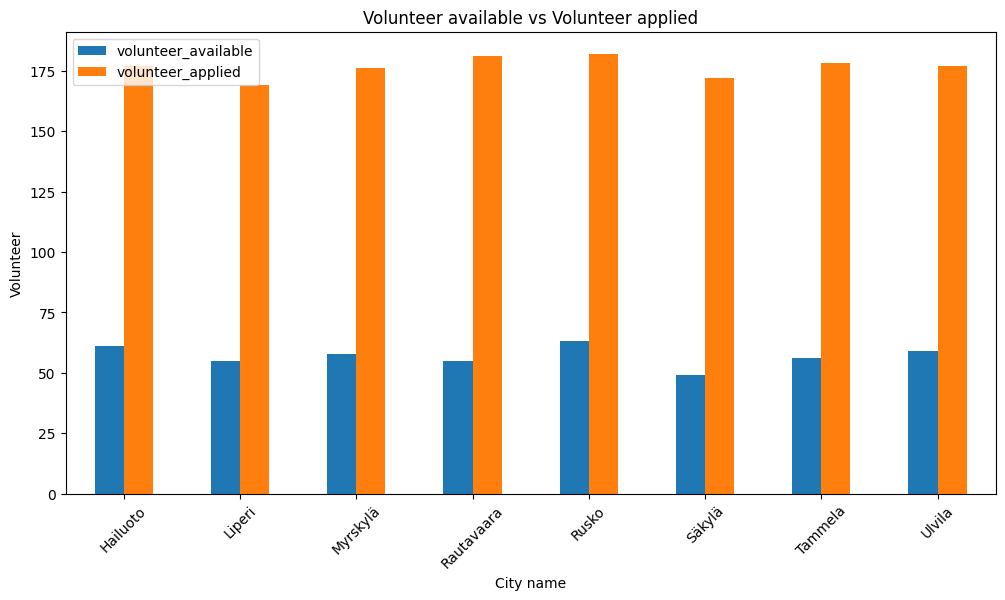

The correlation between volunteer_needed and applied_vonlunteer is: 0.5846153846153848


In [46]:
query = """
select c.name as city_name, a.volunteer_available, b.volunteer_applied
    FROM
        (select city_id, count(*) as volunteer_available 
        from volunteer_range vr 
        group by city_id) a
        join 
        (select rl.city_id, count(distinct va.volunteer_id) as  volunteer_applied
        from request_location rl 
        join volunteer_application va 
        on va.request_id = rl.request_id
        where va.is_valid = true 
        group by rl.city_id) b 
        on a.city_id = b.city_id
        join city c on c.id = a.city_id
        order by a.city_id::numeric;
"""

with connection.cursor() as cur:
    cur.execute(query)
    results = cur.fetchall()
    cur.close()
    
    plt.figure(figsize=(12, 6))
    df = pd.DataFrame(results, columns=['city_name', 'volunteer_available', 'volunteer_applied'])
    print("The number of vonlunteers avaliable and volunteers applied to each city:")
    print(df)
    df.plot(kind='bar',x='city_name', y=['volunteer_available', 'volunteer_applied'], figsize=(12, 6))
    plt.xlabel('City name')
    plt.ylabel('Volunteer')
    plt.title('Volunteer available vs Volunteer applied')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    
    
    correlation = df['volunteer_available'].corr(df['volunteer_applied'])

    print(f"The correlation between volunteer_needed and applied_vonlunteer is: {correlation}")

2. (10p) Create your own scoring system to calculate the matching percentage
from all the attributes of a volunteer that you find relevant: e.g: interest, travel
readiness, volunteer range, number of skill matches, etc. Make a compelling
case for your scoring scheme and suggest a top 5 candidates for each
request according to this system. Does it match the candidates you have
found in past questions?

The ranking framework is based on four criteria: (1) interest match, (2) skill match, (3) location match, and (4) travel readiness. 
Step 1: Filter out potential volunteers applying for requests based on the following conditions:
1.	The volunteer’s interest matches the title (topic) of the request.
2.	The volunteer’s range includes the same locations as the location of the request. The output is the number of cities matched.
3.	The volunteer’s travel readiness is less than 700 minutes (Note: we choose the average travel readiness as the threshold). 
4.	The volunteer has at least one matching skill required by the request.
Step 2: Calculate the score for the following criteria:
1.	Skill matching: the number of matched skills 
2.	Location matching: the number of matched cities, and 
3.	Travel readiness: A score on a 1-4 scale based on four ranges of travel readiness time.
Scaling range for travel readiness: 0 – 200: 1 point, 200 – 400: 0.6 point, 400 – 600: 0.4 point, 600 – 700: 0.2 point.
Note: The score for the 1st condition (i.e. interest match) is the same for all potential volunteers. Therefore, we will only rank the volunteers based on skill match, location match, and travel readiness time from this step onward.
Step 3: Normalized the score of “skill matching” and “location matching” to the range 0 to 1.
Step 4: Define the weights for the criteria: 
•	Skill matching: 50%
•	Location matching: 30%
•	Travel readiness: 20%
Step 5: Calculate the weighted average score for each volunteer in a request based on the three criteria.

In [11]:
query = """
        with cte as(
    select 
        r.id, vr.volunteer_id, 
        count(distinct sa.skill_name) as count_matched_skill,
        count(distinct vr.city_id) as count_matched_city,
        CASE 
            WHEN v.travel_readiness >= 0 AND v.travel_readiness < 200 THEN 1
            WHEN v.travel_readiness >= 200 AND v.travel_readiness < 400 THEN 0.6
            WHEN v.travel_readiness >= 400 AND v.travel_readiness < 600 THEN 0.4
            WHEN v.travel_readiness >= 600 AND v.travel_readiness < 700 THEN 0.2
            ELSE 0 -- This handles any travel_readiness values that do not fit into the specified ranges
        END AS travel_readiness_score 
    from request r 
    join volunteer_application va on va.request_id = r.id 
    join volunteer_range vr on vr.volunteer_id = va.volunteer_id 
    join request_location rl on rl.city_id = vr.city_id and rl.request_id = r.id
    join volunteer v on v.id = vr.volunteer_id
    join skill_assignment sa on sa.volunteer_id =va.volunteer_id 
    join request_skill rs on rs.skill_name = sa.skill_name
    where v.travel_readiness < 700 and va.is_valid = true
    group by r.id, vr.volunteer_id, v.travel_readiness 
    order by cast(r.id as integer) asc 
    ), 
    cte2 as (
    select 
    id, 
    sum(count_matched_skill) as sum_count_matched_skill,
    sum(count_matched_city) as sum_count_matched_city
    from cte 
    group by id 
    order by cast(id as integer) asc 
    )
    select 
    cte.id as request_id, 
    cte.volunteer_id, 
    cte.count_matched_skill/cte2.sum_count_matched_skill as skill_score,
    cte.count_matched_city/cte2.sum_count_matched_city as location_score,
    cte.travel_readiness_score,
    ((cte.count_matched_skill/cte2.sum_count_matched_skill)*0.5 + 
    (cte.count_matched_city/cte2.sum_count_matched_city)*0.3 +
    (cte.travel_readiness_score)*0.2) as overall_score

    from cte
    join cte2 on cte.id= cte2.id
    order by cte.id::numeric, (cte.count_matched_skill/cte2.sum_count_matched_skill)*0.5 + 
    (cte.count_matched_city/cte2.sum_count_matched_city)*0.3 +
    (cte.travel_readiness_score)*0.2 desc
"""

with connection.cursor() as cur:
    cur.execute(query)
    results = cur.fetchall()
    cur.close()
    
    df = pd.DataFrame(results, columns=['request_id', 'volunteer_id', 'skill_score', 'location_score', 'travel_readiness_score', 'overall_score'])
    df_result = df[['request_id', 'volunteer_id']]
    print("Order the vonlunteer for each request based on the our matching system")
    print(df_result)

Order the vonlunteer for each request based on the our matching system
    request_id volunteer_id
0            1  250681-919H
1            1  011074-9149
2            1  211074-9401
3            2  270794-9576
4            2  200569-926L
..         ...          ...
776        380  150400A944B
777        381  150960-943U
778        381  220857-9810
779        381  080474-9161
780        381  150400A944B

[781 rows x 2 columns]


> The result from this query does not matched the result from query 9 because in query 9, we only consider skills as the only requirement. Whereas, multi-criteria decision are made for analysis 2d

3. (5p) For each month, what are the number of valid volunteer applications
compared to the number of valid requests? What months have the most and
least for each, how about the difference between the requests and
volunteers for each month? Is there a general/seasonal trend? Is there any
correlation between the time of the year and number of requests and
volunteers?

The number of request and valid applications for each month:
    month  request_count  application_count
0       1             22                152
1       2             19                147
2       3             28                127
3       4             22                183
4       5             26                217
5       6             41                229
6       7             39                307
7       8             43                238
8       9             43                264
9      10             30                202
10     11             32                222
11     12             37                146


<Figure size 1200x600 with 0 Axes>

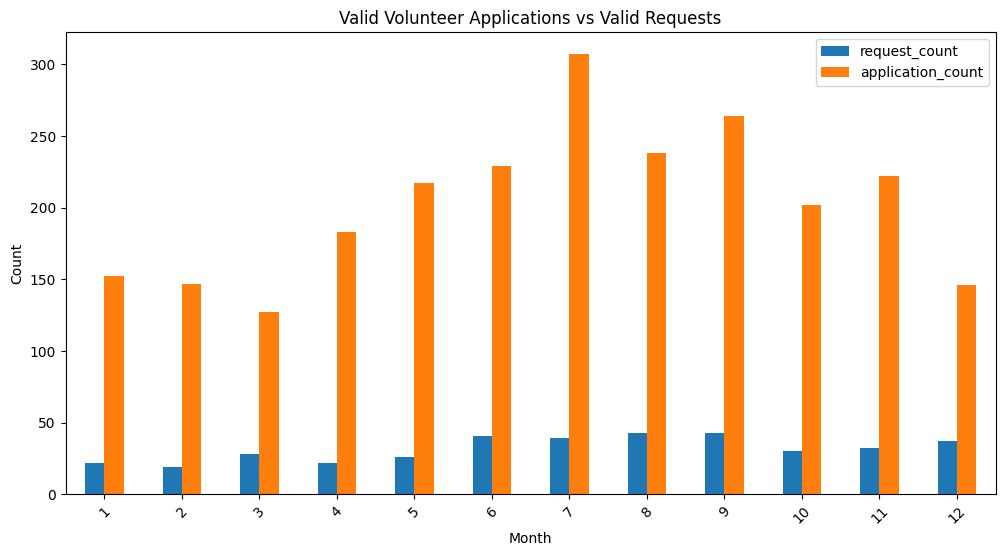

The correlation between volunteer_needed and applied_vonlunteer is: 0.6600108769927279
Month with most valid applications: 7 with 307 applications
Month with least valid applications: 3 with 127 applications
Month with most valid requests: 8 with 43 requests
Month with least valid requests: 2 with 19 requests


<Figure size 1200x600 with 0 Axes>

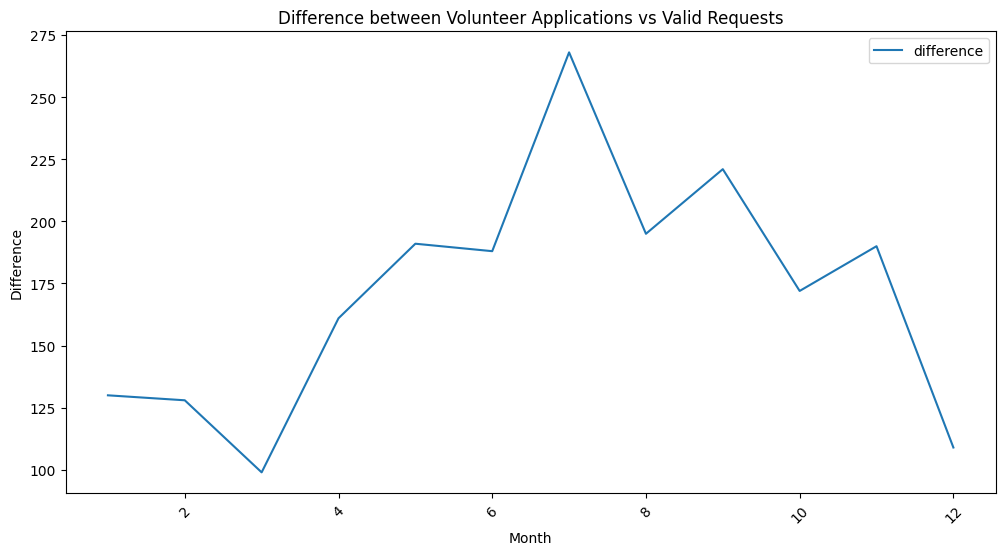

Month with biggest difference between number of requests and number of valid applications: 7


In [48]:
query = """
with request_month as (
    select cast(EXTRACT(MONTH from start_date) as integer) as month, count(*) as request_count from request
    group by month
    order by month
), application_month as (
    select cast(EXTRACT(MONTH from modified) as integer) as month, count(*) as application_count from volunteer_application
    where is_valid = true
    group by month
    order by month
)
select rm.month, rm.request_count, am.application_count from request_month rm join application_month am 
on rm.month = am.month
"""
with connection.cursor() as cur:
    cur.execute(query)
    results = cur.fetchall()
    cur.close()
    
    plt.figure(figsize=(12, 6))
    df = pd.DataFrame(results, columns=['month', 'request_count', 'application_count'])
    print("The number of request and valid applications for each month:")
    print(df)
    df.plot(kind='bar',x='month', y=['request_count', 'application_count'], figsize=(12, 6))
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.title('Valid Volunteer Applications vs Valid Requests')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    
    
    correlation = df['request_count'].corr(df['application_count'])

    print(f"The correlation between volunteer_needed and applied_vonlunteer is: {correlation}")
    
    
    max_applications = df['application_count'].max()
    max_applications_month = df.loc[df['application_count'].idxmax(), 'month']
    min_applications = df['application_count'].min()
    min_applications_month = df.loc[df['application_count'].idxmin(), 'month']
    
    
    max_requests = df['request_count'].max()
    max_requests_month = df.loc[df['request_count'].idxmax(), 'month']
    min_requests = df['request_count'].min()
    min_requests_month = df.loc[df['request_count'].idxmin(), 'month']
    
    
    print(f'Month with most valid applications: {int(max_applications_month)} with {max_applications} applications')
    print(f'Month with least valid applications: {int(min_applications_month)} with {min_applications} applications')
    print(f'Month with most valid requests: {int(max_requests_month)} with {max_requests} requests')
    print(f'Month with least valid requests: {int(min_requests_month)} with {min_requests} requests')
                                                  
    df['difference'] = df['application_count'] -df['request_count']
    plt.figure(figsize=(12, 6))
    df.plot(x='month', y=['difference'], figsize=(12, 6))
    plt.xlabel('Month')
    plt.ylabel('Difference')
    plt.title('Difference between Volunteer Applications vs Valid Requests')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    max_difference = df['difference'].max()
    max_difference_month = df.loc[df['difference'].idxmax(), 'month']
    print(f'Month with biggest difference between number of requests and number of valid applications: {int(max_difference_month)}')

> Conclusion:

A seasonal pattern is evident as the number of applications tends to be higher during the summer compared to the winter.

The largest disparity between the number of requests and the number of valid applications occurs in July.
It is noticeable that the number of requests remains relatively consistent throughout the year, while the number of valid applications experiences a significant increase during the summer months. Therefore, the most significant discrepancy can be observed during certain months in the summer, specifically from June to September.

4. For each skills, analyze the relation between the number of request and the number of applications

<Figure size 1600x1000 with 0 Axes>

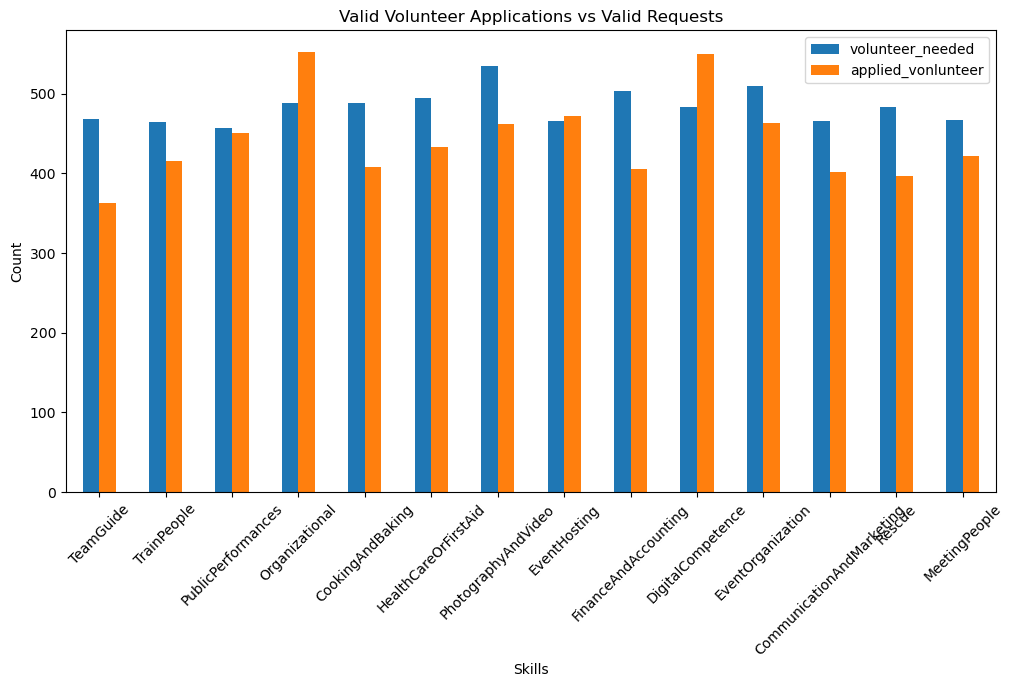

The correlation between volunteer_needed and applied_vonlunteer is: 0.2009416938179232


In [12]:
query = """
with request_skill_count as (
    select rs.skill_name, sum(rs.min_need) as volunteer_needed from request r 
    join request_skill rs on r.id = rs.request_id 
    group by rs.skill_name
),application_skill_count as (
    select sa.skill_name, count(*) as applied_vonlunteer
    from request r  
    join volunteer_application va on r.id = va.request_id 
    join skill_assignment sa on sa.volunteer_id = va.volunteer_id 
    join request_skill rs on rs.request_id = r.id and rs.skill_name = sa.skill_name 
    group by sa.skill_name 
)
select application_skill_count.skill_name, request_skill_count.volunteer_needed, application_skill_count.applied_vonlunteer
from request_skill_count
join application_skill_count on request_skill_count.skill_name = application_skill_count.skill_name 
"""

with connection.cursor() as cur:
    cur.execute(query)
    results = cur.fetchall()
    cur.close()
    
    plt.figure(figsize=(16, 10))
    df = pd.DataFrame(results, columns=['skill_name', 'volunteer_needed', 'applied_vonlunteer'])

    df.plot(kind='bar',x='skill_name', y=['volunteer_needed', 'applied_vonlunteer'], figsize=(12, 6))
    plt.xlabel('Skills')
    plt.ylabel('Count')
    plt.title('Valid Volunteer Applications vs Valid Requests')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    
    
    correlation = df['volunteer_needed'].corr(df['applied_vonlunteer'])

    print(f"The correlation between volunteer_needed and applied_vonlunteer is: {correlation}")

# 4. Matching volunteer: Demand


### Our group choose the proposal 1 to analyze and implement

## 4.1 Proposal 1: Dynamic Matching

In this section, we analyze how to assign the volunteers into request in an effective way. In this part, we create a table assigned_volunteer with 2 columns (request_id, volunteer_id)

We classify the requests into 2 types:
- Oversupply requests: is requests whose number of applicants is higher than number of volunteers needed
- Undersupply requests: is requests whose number of applicants is lower than number of volunteers needed

With each type of request, we have different strategy to assign the volunteers into request
- Undersupply requests: we assign all the applied volunteers to the request
- Oversupply requests: we use the our developed matching system mentioned in question 2 of section Analysis to single out and order the potenital volunteer based on some criterias

In [17]:
create_table_query = """
CREATE TABLE IF NOT EXISTS assigned_volunteer (
    request_id VARCHAR,
    volunteer_id VARCHAR
)
"""


with connection.cursor() as cur:
    cur.execute(create_table_query)
    cur.close()

In [18]:
# find the request which has the number of applicants lower than the number of volunteers needed. We called it undersupply request
# after that, we assign all the applied volunteer to the request
under_supply_query = """
    with cte as (select va.request_id, count(*) from volunteer_application va 
    join request r  on va.request_id = r.id 
    group by va.request_id, r.number_of_volunteers  
    having count(*) <= r.number_of_volunteers 
    order by cast(va.request_id as integer) asc)
    select cte.request_id,volunteer_application.volunteer_id  from cte join volunteer_application on cte.request_id = volunteer_application.request_id 

"""

with connection.cursor() as cur:
    cur.execute(under_supply_query)
    results = cur.fetchall()
    update_sql = "INSERT INTO assigned_volunteer (request_id, volunteer_id) VALUES (%s, %s)"
    df = pd.DataFrame(results, columns=['request_id', 'volunteer_id'])
    for _, row in df.iterrows():
        cur.execute(update_sql, (row['request_id'], row['volunteer_id']))
    cur.close()
    print(df)

     request_id volunteer_id
0             1  211074-9401
1             1  230283-963X
2             1  250681-919H
3             1  210753-990T
4             1  211099-910H
...         ...          ...
2055        382  020759-9272
2056        382  210694-902R
2057        382  220490-940Y
2058        382  200472-937X
2059        382  010573-901K

[2060 rows x 2 columns]


In [19]:
# find the request which has the number of applicants higher than the number of volunteers needed. We called it oversupply request
# after that, we calculate the score of each volunteer based on 3 criteria: the number of skills matched, the number of cities matched, the travel readiness
# each criteria will be multiplied with a single weight which represents the importance of the criteria
# after that, we rank the volunteer based on the overall score and assigned them to the respective request
oversupply_query = """
    with oversupply_request as (
    select va.request_id, count(*) from volunteer_application va 
    join request r  on va.request_id = r.id 
    group by va.request_id, r.number_of_volunteers  
    having count(*) > r.number_of_volunteers 
    order by cast(va.request_id as integer) asc
 ),oversupply_request_and_volunteer as (
    select oversupply_request.request_id,volunteer_application.volunteer_id  from oversupply_request join volunteer_application on oversupply_request.request_id = volunteer_application.request_id 
)
    ,cte as(
    select 
        r.id, vr.volunteer_id, 
        count(distinct sa.skill_name) as count_matched_skill,
        count(distinct vr.city_id) as count_matched_city,
        CASE 
            WHEN v.travel_readiness >= 0 AND v.travel_readiness < 200 THEN 1
            WHEN v.travel_readiness >= 200 AND v.travel_readiness < 400 THEN 0.6
            WHEN v.travel_readiness >= 400 AND v.travel_readiness < 600 THEN 0.4
            WHEN v.travel_readiness >= 600 AND v.travel_readiness < 700 THEN 0.2
            ELSE 0 -- This handles any travel_readiness values that do not fit into the specified ranges
        END AS travel_readiness_score 
    from request r 
    join volunteer_application va on va.request_id = r.id 
    join volunteer_range vr on vr.volunteer_id = va.volunteer_id 
    join request_location rl on rl.city_id = vr.city_id and rl.request_id = r.id
    join volunteer v on v.id = vr.volunteer_id
    join skill_assignment sa on sa.volunteer_id =va.volunteer_id 
    join request_skill rs on rs.skill_name = sa.skill_name
    where v.travel_readiness < 700 and va.is_valid = true
    group by r.id, vr.volunteer_id, v.travel_readiness 
    order by cast(r.id as integer) asc 
    ), 
    cte2 as (
    select 
    id, 
    sum(count_matched_skill) as sum_count_matched_skill,
    sum(count_matched_city) as sum_count_matched_city
    from cte 
    group by id 
    order by cast(id as integer) asc 
    )
    select 
    cte.id as request_id, 
    cte.volunteer_id, 
    cte.count_matched_skill/cte2.sum_count_matched_skill as skill_score,
    cte.count_matched_city/cte2.sum_count_matched_city as location_score,
    cte.travel_readiness_score,
    ((cte.count_matched_skill/cte2.sum_count_matched_skill)*0.5 + 
    (cte.count_matched_city/cte2.sum_count_matched_city)*0.3 +
    (cte.travel_readiness_score)*0.2) as overall_score

    from cte
    join cte2 on cte.id= cte2.id
    join oversupply_request_and_volunteer on cte.id=oversupply_request_and_volunteer.request_id and cte.volunteer_id = oversupply_request_and_volunteer.volunteer_id
    order by cte.id::numeric, (cte.count_matched_skill/cte2.sum_count_matched_skill)*0.5 + 
    (cte.count_matched_city/cte2.sum_count_matched_city)*0.3 +
    (cte.travel_readiness_score)*0.2 desc
    
"""
with connection.cursor() as cur:
    cur.execute(oversupply_query)
    results = cur.fetchall()
    update_sql = "INSERT INTO assigned_volunteer (request_id, volunteer_id) VALUES (%s, %s)"
    df = pd.DataFrame(results, columns=['request_id', 'volunteer_id','skill_score','location_score','travel_readiness_score','overall_score'])
    for _, row in df.iterrows():
        cur.execute(update_sql, (row['request_id'], row['volunteer_id']))
    cur.close()
    print(df)

    request_id volunteer_id             skill_score          location_score  \
0           14  031161-910W  0.46666666666666666667  0.33333333333333333333   
1           14  090484-900R  0.46666666666666666667  0.33333333333333333333   
2           14  190690-943R  0.06666666666666666667  0.33333333333333333333   
3           19  080767-948N  0.50000000000000000000  0.50000000000000000000   
4           19  080474-9161  0.50000000000000000000  0.50000000000000000000   
..         ...          ...                     ...                     ...   
182        375  150960-943U  0.14893617021276595745  0.09090909090909090909   
183        375  220857-9810  0.17021276595744680851  0.27272727272727272727   
184        375  060963-9833  0.10638297872340425532  0.18181818181818181818   
185        375  060761-917U  0.14893617021276595745  0.09090909090909090909   
186        375  140387-9064  0.19148936170212765957  0.09090909090909090909   

    travel_readiness_score            overall_score

In [20]:
# now we can see the assigned_volunteer table
query = """
    select * from assigned_volunteer order by cast(request_id as integer) asc
"""

with connection.cursor() as cur:
    cur.execute(query)
    results = cur.fetchall()
    cur.close()
    
    plt.figure(figsize=(16, 10))
    df = pd.DataFrame(results, columns=['request_id', 'volunteer_id'])
    
    print(df)

     request_id volunteer_id
0             1  160903A941P
1             1  230283-963X
2             1  210753-990T
3             1  211099-910H
4             1  250681-919H
...         ...          ...
2242        382  231269-913S
2243        382  020759-9272
2244        382  210694-902R
2245        382  220490-940Y
2246        382  010573-901K

[2247 rows x 2 columns]


<Figure size 1600x1000 with 0 Axes>